In [3]:
import numpy as np
import pandas as pd
import scipy as sc
from scipy.stats import randint,norm,multivariate_normal, ortho_group
from scipy import linalg
from scipy.linalg import subspace_angles,orth
from scipy.optimize import fmin
import math
from statistics import mean 
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import itertools as it
import seaborn as sns
import matplotlib.pyplot as plt
#from cluster.selfrepresentation import ElasticNetSubspaceClustering

# 1. Simulation Study, Noiseless case. Simulate data according to the model above with the following parameters:
- n = 2^3,2^4,...,2^10.
- p = 2^4,2^5,2^6,2^ d 7.
- d = 2^(−1)p, 2^(−2)p, 2^(−3)p,2^(−4)p, for each of the values of p.
- K = 4 clusters.
- θ = 10^(−2)θmax, 10^(−1)θmax, θmax, where θmax is the value obtained on average by taking

In [5]:
# functions for simulate data
def first_simulatin(p,dim,k):
  b = [orth(np.random.rand(p, dim)) for k in range(k+1)]
  return (b)

def find_theta_max(b,t,k):
  theta_max = []
  for  i in range(1,k+1) :
    for j in range(1,i):
      theta_max.append(subspace_angles(b[i],b[j]).max())
  max_avg_theta = mean(theta_max) 
  theta = max_avg_theta*t
  return (theta)

def second_simulation(p,k,dim,theta,b) :
  def find_a_for_theta(a,b=b,k=k,theta=theta) :
    temp_theta = []
    for  i in range(1,k+1) :
      for j in range(1,i):
        temp_theta.append(subspace_angles(b[0]*(1-a)+b[i]*a,b[0]*(1-a)+b[j]*a).max())
    return (mean(temp_theta)-theta)
  a= sc.optimize.bisect(find_a_for_theta,0,1)
  B = [b[0]*(1-a)+b[i]*a for i in range(1,k+1)]
  return (B)

def third_simulation(n,p,dim,B,k,theta) :
  z = np.random.randint(0,k,n)  
  w = np.random.multivariate_normal(mean = np.zeros(dim),cov =np.diag(np.ones(dim)),size=n)
  X= np.zeros((n,p))
  for i in range(n):
    X[i,] = np.random.multivariate_normal(mean = np.array(np.dot(np.matrix(w[i,:]),B[z[i]].T)).flatten(),cov = np.diag(np.ones(p)))  #sigma value is missing 
  return (n,p,dim,theta,X,z,B)


In [6]:
#data simulation
def final_data_simulation(k) :
  nn = [2 ** j for j in range(3,11)]
  pp = [2 ** j for j in range(4,8)]   
  dd = [2 ** -j for j in range(1,5)] 
  tt = [10 ** -j for j in range(0,3)] 
  df = pd.DataFrame(columns=['n', 'p', 'dim','theta','X','z','B'])
  for p in pp: 
    for d in dd:
      dim = int(d*p)
      b= first_simulatin(p=p,dim=dim,k=k)
      for t in tt :
        theta= find_theta_max(b=b,t=t,k=k)
        for n in nn: 
          B= second_simulation(p=p,k=k,dim=dim,theta=theta,b=b)
          row=pd.Series(list(third_simulation(n=n,p=p,dim=dim,B=B,k=k,theta=theta)[0:7]),["n","p","dim","theta","X","z","B"])
          df= df.append([row],ignore_index=True)
  return (df)



In [7]:
df = final_data_simulation(4)

In [25]:
X = df['X'][31]
z = df['z'][31]
z

array([1, 1, 2, ..., 1, 0, 1])

In [53]:
dim = 4
p = 16
k=4
kmeans = KMeans(n_clusters=k)
kmeans
temp_df = pd.DataFrame(X)
temp_df['cluster'] = kmeans.fit_predict(X)
#for i in range(k) :
i = 1 
df_new= temp_df[temp_df['cluster']==i].drop(['cluster'],axis=1)
cluster_kmean= KMeans(n_clusters=k).fit_predict(X)
data = {'cluster1': z,'cluster2': cluster_kmean} 
clusters = pd.DataFrame(data, index=range(len(z)))
all_per = list(it.permutations(range(k)))
accuracy_rate_all_per = np.zeros(len(all_per))
c = [i for i in range(k)]
for l, p in enumerate(all_per) :
  dic = dict(zip(c,p))
  clusters['premut_cluster'] = clusters['cluster2'].transform(lambda x: dic[x] if x in dic else None)
  m = clusters.groupby(['cluster1','premut_cluster']).size().unstack(fill_value=0)
  accuracy_rate_all_per[l]=np.trace(m)
accuracy_rate_all_per.max() , len(cluster_kmean) 

(293.0, 1024)

In [49]:
per =all_per[2]
dic = dict(zip(c,per))
clusters['premut_cluster'] = clusters['cluster2'].transform(lambda x: dic[x] if x in dic else None)
clusters.groupby(['cluster2','premut_cluster']).size()

cluster2  premut_cluster
0         0                 269
1         2                 268
2         1                 246
3         3                 241
dtype: int64

In [235]:
# find kmeans clusters and subspaces
def pca_subspace(df,i,dim):
  df_new= df[df['cluster']==i].drop(['cluster'],axis=1)
  pca_components_number = len(df_new)-1 if len(df_new)<dim  else dim #handling with low  n (lower than dim)
  pca = PCA(n_components=pca_components_number)
  pca.fit_transform(df_new)
  B_kmeans = pca.components_
  return (B_kmeans.T)

def find_kmeans_subspace(X,k,dim):
  kmeans = KMeans(n_clusters=k)
  temp_df = pd.DataFrame(X)
  temp_df['cluster'] = kmeans.fit_predict(X)
  B_kmean = [pca_subspace(temp_df,i,dim) for i in range(k)]
  return (B_kmean)

def find_ensc_subspace(X,k,dim):
  temp_df = pd.DataFrame(X)
  temp_df['cluster']  = ElasticNetSubspaceClustering(n_clusters=k,algorithm='lasso_lars',gamma=50).fit(X.T)
  B_ensc = [pca_subspace(temp_df,i,dim) for i in range(k)]
  return (B_ensc)

In [233]:
#Recovery Performance
def performance_measure1(k,B1,B2): 
  all_per = list(it.permutations(range(k)))
  sum_cos_angles_all_per = np.zeros(len(all_per))
  for l, val in enumerate(all_per):
    for i in range(k) : 
      if B2[val[i]].shape[1]>0 : # handling with empty clusters
        sum_cos_angles_all_per[l]+= (math.cos(subspace_angles(B1[i],B2[val[i]]).max()))**2   #use min or max????????????????
  cost_subspace = sum_cos_angles_all_per.max()
  return (cost_subspace)

  # WHAT ARE WE DOING WITH EMPTY CLUSTERS 
def performance_measure2(k,cluster1,cluster2):
  data = {'cluster1': cluster1,'cluster2': cluster2} 
  clusters = pd.DataFrame(data, index=range(len(cluster1)))
  all_per = list(it.permutations(range(k)))
  accuracy_rate_all_per = np.zeros(len(all_per))
  for l, per in enumerate(all_per) :
    c = [i for i in range(k)]
    dic = dict(zip(c,per))
    clusters['premut_cluster'] = clusters['cluster2'].transform(lambda x: dic[x] if x in dic else None)
    m = clusters.groupby(['cluster1','premut_cluster']).size().unstack(fill_value=0)
    accuracy_rate_all_per[l]=np.trace(m)
  cost_cluster = (accuracy_rate_all_per.max())/len(cluster1) 
  return (cost_cluster)   


In [242]:
def all_process(k): 
    df = final_data_simulation(k)
    df['B_kmean'] = df.apply(lambda x: find_kmeans_subspace(x['X'], k, x['dim']), axis=1)
    df['cluster_kmean']=df.apply(lambda x: KMeans(n_clusters=k).fit_predict(x['X']), axis=1) #try to return the clusters in "find_kmeans_subspace"
   # df['B_ensc'] = df.apply(lambda x: find_ensc_subspace(x['X'], k, x['dim']), axis=1)
   # df['cluster_ensc']=df.apply(lambda x: ElasticNetSubspaceClustering(n_clusters=k,algorithm='lasso_lars',gamma=50).fit(x['X'].T), axis=1) 
    return (df)

In [1]:
measure1_kmean = pd.DataFrame()
measure2_kmean = pd.DataFrame()
k = 4 
for iter in range(2) :
  df = all_process(k)
  measure1_kmean.insert(iter, "", df.apply(lambda x: performance_measure1(k, x['B'], x['B_kmean']), axis=1), True) 
  measure2_kmean.insert(iter, "", df.apply(lambda x: performance_measure2(k, x['z'], x['cluster_kmean']), axis=1), True)
#  measure1_ensc.insert(iter, "", df.apply(lambda x: performance_measure1(k, x['B'], x['B_ensc']), axis=1), True) 
# measure2_ensc.insert(iter, "", df.apply(lambda x: performance_measure2(k, x['z'], x['cluster_ensc']), axis=1), True) 
df['measure1_kmean'] = measure1_kmean.apply(lambda x: mean(x), axis=1)
df['measure2_kmean'] = measure2_kmean.apply(lambda x: mean(x), axis=1)
#df['measure1_ensc'] = measure1_ensc.apply(lambda x: mean(x), axis=1)
#df['measure2_ensc'] = measure2_ensc.apply(lambda x: mean(x), axis=1)
df['theta_degree'] = df.apply(lambda x: math.degrees(x['theta']), axis=1)


NameError: ignored

0.001229525030258541

In [223]:
#ploting 
def plotting_performance_measure(df,measure):
  pp = [2 ** j for j in range(4,8)]   
  dd = [2 ** -j for j in range(1,5)] 
  plt.title("PERFORMANCE MEASURE1 - KMEANS")
  i= 1
  for p in pp:
    for d in dd:
      dim = int(d*p)
      sns_df = df[(df['p']==p) & (df['dim']==dim)]
      sns_df = sns_df.pivot("theta_degree", "n", measure)
      plt.subplot(4, 4,i)
      ax = sns.heatmap(sns_df)
      plt.title('p= {p} ,dim= {dim} '.format(p=p, dim=dim))
      i+=1

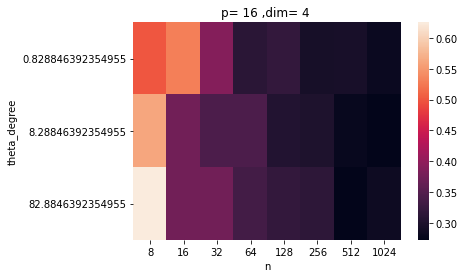

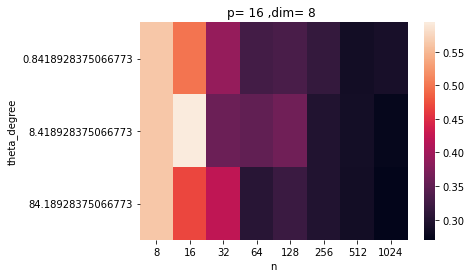

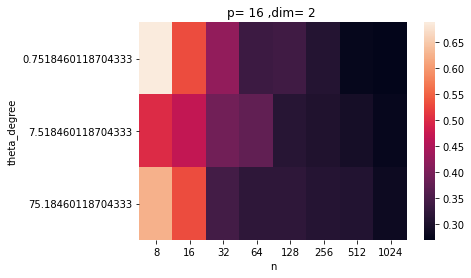

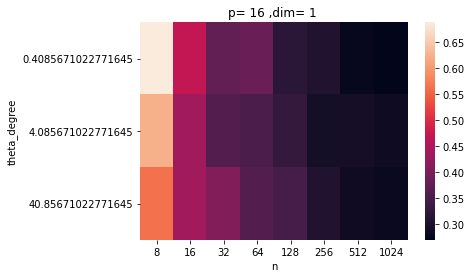

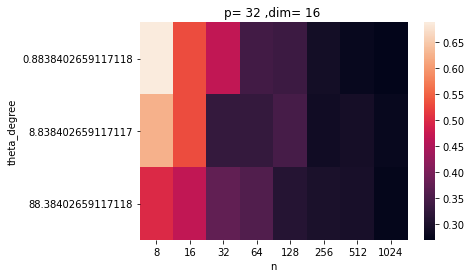

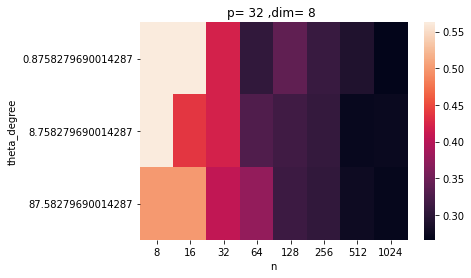

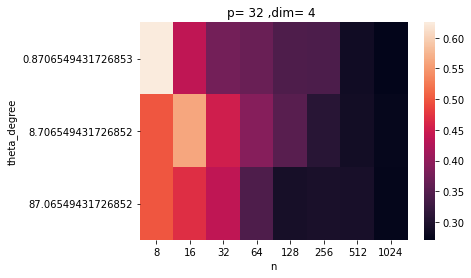

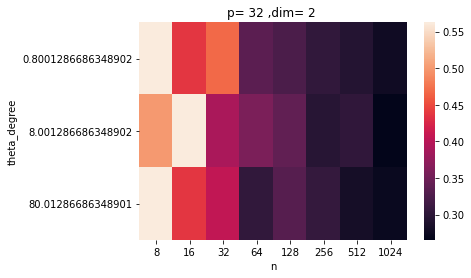

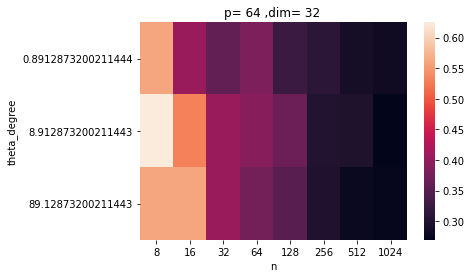

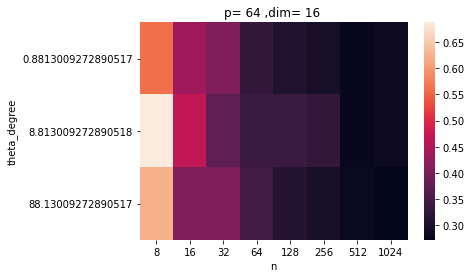

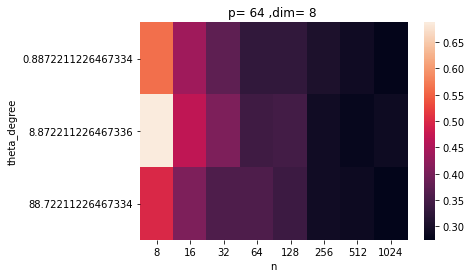

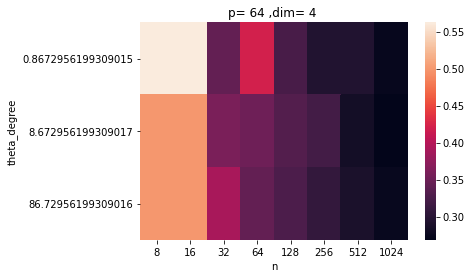

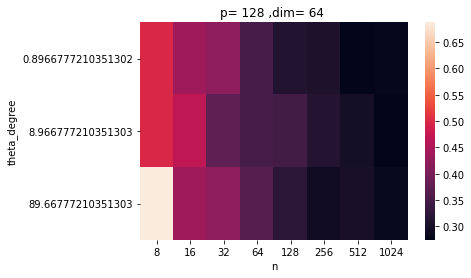

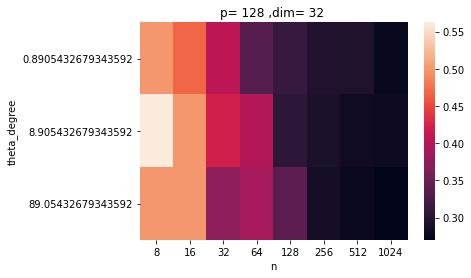

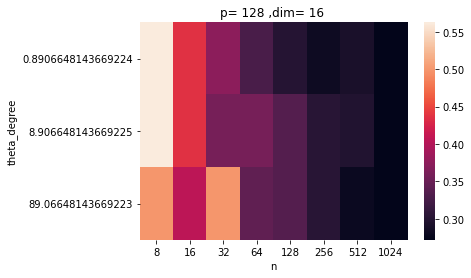

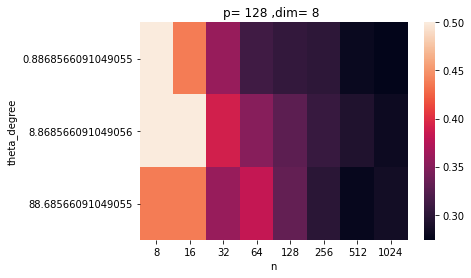

In [224]:
plotting_performance_measure(df,"measure1_kmean")
plotting_performance_measure(df,"measure2_kmean")
plotting_performance_measure(df,"measure1_ensc")
plotting_performance_measure(df,"measure2_ensc")